In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, LineCollection
import matplotlib.path as mpath
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import sys
sys.path.append("/home/miguel/apps/baltic3")
sys.path.append("/home/miguel/tmp/who-2018b")
sys.path.append("/home/miguel/apps/automata")

import numpy as np
import pandas as pd
import time
import json

import xio

import baltic3 as bt
import baltic3_utils as btu


def draw_gbars(axis_object, my_gtype_dict, fontsize, verbose=True):
    """Draw genotype bars on the given axis object. 
    """
    
    gtype_bars_ls = []
    for k in list(my_gtype_dict.keys()):
        gtype_bars_ls.append(gtype_bars_dict[k])
        y0 = my_gtype_dict[k][0][-1]
        y1 = my_gtype_dict[k][1][-1]
        y_text = np.mean([y0, y1])
    
        # add directly to input axis object
        x_text = gtype_bars_dict[k][0][0]*0.99
        axis_object.text(x_text, y_text, 
                         k, 
                         rotation=90,
                         horizontalalignment="center",
                         verticalalignment="center", 
                         fontsize=fontsize)
        if verbose:
            print("%s printed at (%.4f, %.4f)" % (k, x_text, y_text))
    
    return gtype_bars_ls

In [6]:
from collections import OrderedDict

path1 = "2nd_treesub_yam_2019"

dm = btu.treesub_to_bt(path1+"/treesub/substitutions.tree", path1+"/treesub/subs2.tre")

tre = btu.austechia_read_tree(path1+"/treesub/subs2.tre")

# branch nonsyn subs
dm = pd.read_csv(path1+"/treesub/subs.csv")
# create dict, branch_dict{}, from dm
branch_dict = {}
for index, row in dm.iterrows():
    if row["nonsynsubs"] != "*":
        branch_dict[str(row["node_num"])] = row["nonsynsubs"]

# metadata
dm1 = pd.read_csv(path1+"/BYam_fortree_nodup_ready.csv")
dm1 = dm1.fillna("NA")

#with open('data/2nd_cdict_2019_yam.json') as f:
#    c_dict = json.load(f)
c_dict = json.load(open('data/2nd_cdict_2019_yam.json'), object_pairs_hook=OrderedDict)


#NEXUS
begin taxa;
dimensions ntax=27;
taxlabels
'B/MASSACHUSETTS/02/2012'
'B/WISCONSIN/01/2010'
'B/PHUKET/3073/2013'
'B/SOUTHAUSTRALIA/11/2019'
'B/SOUTHAUSTRALIA/12/2019'
'B/SOUTHAUSTRALIA/8/2019'
...
begin trees;
tree TREE1 = [&R] (('B/MASSACHUSETTS/02/2012':0.00...
end;

Written out to file 2nd_treesub_yam_2019/treesub/subs2.tre

Tree height: 0.015921
Tree length: 0.046187
strictly bifurcating tree
annotations present

Numbers of objects in tree: 53 (26 nodes and 27 leaves)



In [7]:
# =================================== PARAMS ===================================
# ===== LAYOUT =====
fig_h = 14.85 # figure height
fig_w = 10.5 # figure width
# Note: A4 proportions are 210 x 297 mm. 

# ===== TREE PARAMS =====
branchWidth=1.01 # line thickness of branches
x_offset= 0.0001
#It may be necessary to push the tree to the left to make room for the legend
#Otherwise, set this to an arbitrarily small number
outgroup_name = "B/FLORIDA/4/2006"


# ===== TRACK PARAMS =====
track_x = tre.treeHeight*1.35 # distance from the left edge of the leftmost track to the tree. 
track_width = 0.0005 # width of each track
track_height_factor = 1 # track_height = branchWidth * track_height_factor
track_label_y = -0.1 # distance between the bottom of the track and the labels
track_fontsize = 6

track_cols = []
for col in list(dm1.columns):
    if col != "desig":
        track_cols.append(col)

# ===== TIPNAMES & C/N LINES =====
tipname_x = tre.treeHeight * 1.09 #IMPORTANT
tipname_fontsize = 6
dotted_line_c = '#7a9fa5'

# TEXT PARAMS
title_text = "Yamagata (HA)\n(Feb to Sep 2019)" # \n creates a new line
title_text_size = 22
title_x = 0.0001
title_y = tre.ySpan
aa_fontsize = 5
aa_label_x_offset = 0.00005 # distance from node label to node
aa_label_y_offset = 0.1 # vertical distance from node label to node


# ===== LEGEND =====
#side lengths of legend squares
#Square size (higher~bigger)
sidelen_x = 0.0007 
sidelen_y = 0.5
#position
legend_x0 = 0.0015 # bottom-left x-coord of legend squares
legend_x1 = 0.00155
legend_y0 = 24 # bottom-left y-coord of the highest legend square. 
#xy_factor=80 # DEPRECATED?
padding_factor= 1.15
# increases vertical spacing between squares, as a multiple of sidelen
legend_fontsize=8

# SCALEBAR
sb_y = -1
sb_x0 = 0.002
sb_width=0.0001
sb_fontsize=10


# OTHER
save_fn = "2nd_yam_2019.pdf" 
# Saves the figure to a pdf. 
# If you don't want to save, set: save_fn = ""

leaf_ycoord_min = min([x.height for x in tre.leaves])


# ===== GENOTYPE BAR PARAMS =====
bar_x0 = 0.0305
gbar_fontsize = 11
gtype_bars_dict = {}
#gtype_bars_dict = {"Y3":[[bar_x0, 3.5], [bar_x0, tre.ySpan+0.5]],
#                  "Y2":[[bar_x0, 2.5], [bar_x0, 1.5]], 
#                  "Y1":[[bar_x0, 0.5], [bar_x0, -0.5]]}


Saving as 2nd_yam_2019.pdf
Done in 0.71s


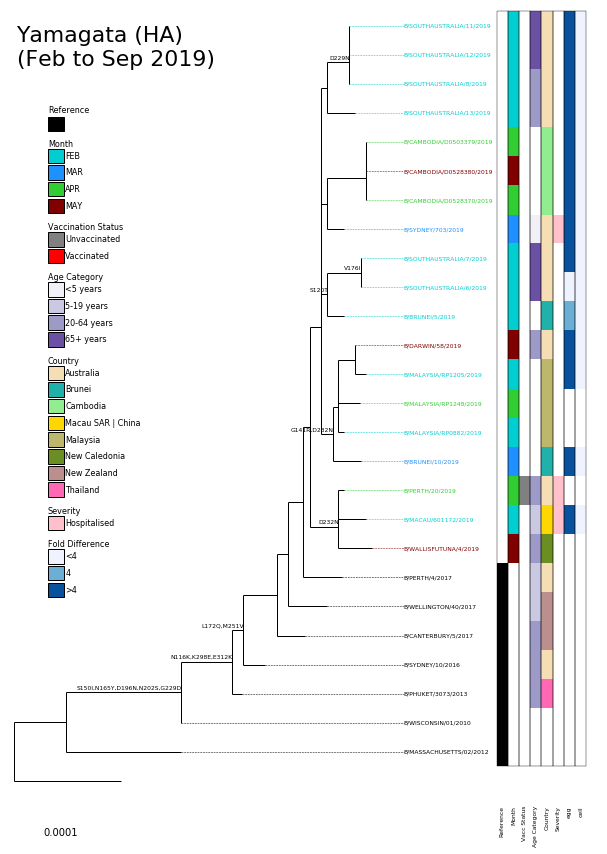

In [8]:
t0 = time.time()
fig,ax = plt.subplots(figsize=(fig_w, fig_h),facecolor='w')

dotted_lines_ls = []
branch_lines_ls = []


for k in tre.Objects:
    c = 'k'
    x=k.height
    y=k.y

    xp = k.parent.height
    if x is None: # matplotlib won't plot Nones, like root
        x = x_offset
    if xp==None:
        xp = x + x_offset


    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        if k.name != outgroup_name: # don't draw outgroup
            # draw dotted lines and tipnames
            
            d_t = dm1.loc[dm1["desig"]==k.name]
            tipname_c = "k" #default
            if len(d_t) != 1:
                print("WARNING: metadata not found for %s!" % k.name)
            else: 
                mth = d_t["Month|Month"].values[0]
                tipname_c = c_dict["Month"][mth]
                if tipname_c == "white":
                    tipname_c = "k"

            ax.text(tipname_x, y, k.name, 
                    fontsize=tipname_fontsize, 
                    color=tipname_c,
                    verticalalignment='center')
            
            # tiplines
            ax.plot([x, tipname_x], [y, y], 
                    ls="--", 
                    lw=branchWidth/2, 
                    color=tipname_c)
            
            # ===== draw tracks =====
            # Get actual values from dm1 to lookup colour values
            d_temp = dm1.loc[dm1["desig"]==k.name]
            if len(d_temp) != 1:
                print("Tipname not found in dm1!")

            for i in range(len(track_cols)):
                col_key = track_cols[i].split("|")[-1]
                if "Fold Diff" in col_key:
                    # Override to check that all 'FD(egg)', 'FD(cell)'...
                    # and other such variants will lookup "Fold Difference"
                    col_key = "Fold Difference"
                
                val = d_temp[track_cols[i]].values[0] # actual value
                
                # type conversion, because some values are not str
                # For those that are int, convert to int first to remove decimal places
                # then to str, because the colour dict has only strings
                # Carry out the replacement operation regardless
                val = str(val).replace(".0", "")
                

                colour = c_dict[col_key][val]
                rect = patches.Rectangle((track_x+(i*track_width),y-0.5), #(x,y)-coords
                                         track_width, # width
                                         branchWidth*track_height_factor, # height
                                         linewidth=0,
                                         edgecolor=colour,
                                         facecolor=colour,
                                         zorder=9)
                ax.add_patch(rect)
        
    elif isinstance(k,bt.node) or k.branchType=='node':

        line=np.array([[x, k.children[-1].y], [x, k.children[0].y]])
        branch_lines_ls.append(line)
        
    # ========= aa change labels =========
    # Add aa-sub labels by looking up branch_dict{}
        if k.traits != {}:
            # WARNING: Manual bypass, will not allow errors to fail explicitly!
            # Required atm because the first node (root) has no trait dictionary.
            # do a type conversion as well, just in case. We need it as a string
            br_num = str(k.traits['NUMBER'])
            if br_num in list(branch_dict.keys()): 
                # WARNING: Again, a bypass.
                aa_label_str = branch_dict[str(br_num)]
            
                ax.text(x+aa_label_x_offset, 
                        y+aa_label_y_offset, 
                        aa_label_str, fontsize=aa_fontsize+1, 
                        horizontalalignment='right')

    # Draw horizontal lines
    line=np.array([[x, y], [xp, y]])
    branch_lines_ls.append(line)

# Title text
ax.text(title_x, title_y, title_text, 
        fontsize=title_text_size,
        verticalalignment="top")


# ==================== black border around tracks ====================
# Draw a transparent rect with black border behind tracks
track_rect_ht = len(tre.Objects)
for i in range(len(track_cols)):
    # +0.5 so that the dotted lines point to the middle of each track rectangle
    rect = patches.Rectangle((track_x+(i*track_width),leaf_ycoord_min+1.5), #(x,y)-coords
                             track_width, # width
                             tre.ySpan-1.0, # height
                             linewidth=0.4,
                             edgecolor="k",
                             fill=False,
                             zorder=10)
    ax.add_patch(rect)
    # Add track labels
    track_label = track_cols[i].split("|")[-1]
    if "(egg)" in track_label:
        track_label = "egg"
    elif "(cell)" in track_label:
        track_label = "cell"
    elif "Vaccination" in track_label:
        track_label = "Vacc Status"
    ax.text(track_x+(i*track_width)+(track_width*0.5), 0., 
            track_label, 
            fontsize=track_fontsize,
            horizontalalignment="center",
            rotation=90, 
            zorder=15)

# ==================== Gtype bars ====================
gtype_bars_ls = draw_gbars(ax, gtype_bars_dict, fontsize=gbar_fontsize)


# ========== legend ==========
# This specific plot requires one column
idx = 0
# Don't use legend.keys() so you can control the order of iteration
legend_ls = ["Reference", "Month",
             "Vaccination Status", "Age Category","Country","Severity","Fold Difference"]

for k in legend_ls:
    # Subtitles for the legend
    ax.text(legend_x0, legend_y0-(idx*sidelen_y*padding_factor), 
            k, fontsize=legend_fontsize)
    idx +=1
    # Treat "Reference" separately
    # HARDCODED
    if k == "Reference":
        rect = patches.Rectangle((legend_x0,legend_y0-(idx*sidelen_y*1.25)), #(x,y)-coords
                                 sidelen_x,sidelen_y, #width, height
                                 linewidth=1,
                                 edgecolor='black',
                                 facecolor="black")
        ax.add_patch(rect)
        idx +=1
    
    elif k != "Reference":
        for k2 in list(c_dict[k].keys()):
            if (k2 != "NA") and (k2 != "FEB2"):
                # Legend text
                ax.text(legend_x0+sidelen_x*1.1, 
                        legend_y0-(idx*sidelen_y*padding_factor)+(0.5*sidelen_y), 
                        k2, 
                        fontsize=legend_fontsize, 
                        verticalalignment="center")
                c_rect = c_dict[k][k2] # get square colour
                rect = patches.Rectangle((legend_x0,legend_y0-(idx*sidelen_y*padding_factor)), #(x,y)-coords
                                         sidelen_x,sidelen_y, #width, height
                                         linewidth=1,edgecolor='black',facecolor=c_rect)
                ax.add_patch(rect)
                idx +=1
                

# ==================== Collections ====================
gtype_bars_collection = LineCollection(gtype_bars_ls, 
                                        lw=branchWidth*1.5,
                                        color='k', 
                                        zorder=11)
ax.add_collection(gtype_bars_collection)
dotted_line_collection = LineCollection(dotted_lines_ls, 
                                        lw=branchWidth/2,
                                        color='k', 
                                        zorder=11, 
                                        alpha=0.3)
ax.add_collection(dotted_line_collection)
br_lines_collection = LineCollection(branch_lines_ls, 
                                     lw=branchWidth,
                                     color="k",
                                     zorder=10,)
ax.add_collection(br_lines_collection)

#Total margins
ax.set_ylim(-tre.ySpan*0.01, tre.ySpan*1.02)
ax.set_xlim(-tre.treeHeight*0.01, tre.treeHeight*1.63)

# Scale bar
ax.plot([sb_x0, sb_x0+sb_width], [sb_y, sb_y], c="k", lw=branchWidth*1.5)
ax.text(sb_x0+(0.5*sb_width), sb_y*0.9, str(sb_width), 
        color="k", 
        fontsize=sb_fontsize, 
        horizontalalignment="center")


ax.set_yticks([])
ax.set_xticks([])
plt.axis('off')

if len(save_fn) > 0:
    plt.savefig(save_fn, bbox_inches="tight")
    print("Saving as %s" % save_fn)


print("Done in %.2fs" % (time.time() - t0))

plt.show()

In [9]:
for lf in tre.leaves:
    if "HUBEI" in lf.name:
        print(lf.y)